In [1]:
from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch

In [2]:
print()
print('loading saved coeffs..')
loaded_coeffs = torch.load('/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/lag_coeffs_saved/train_lag_coeffs_indiv_deg30.pt')
print()
print('printing shape of loaded coeffs', loaded_coeffs.shape)


loading saved coeffs..

printing shape of loaded coeffs torch.Size([7626, 1, 736])


In [3]:
print()
print('loading saved coeffs test..')
loaded_coeffs_tst = torch.load('/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/lag_coeffs_saved/test_lag_coeffs_indiv_deg30.pt')
print()
print('printing shape of loaded coeffs', loaded_coeffs_tst.shape)


loading saved coeffs test..

printing shape of loaded coeffs torch.Size([1968, 1, 736])


In [9]:
#lets see experiment
loaded_train = torch.load('/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/lag_coeffs_saved/train_data.pt', map_location=torch.device('cpu'))
print('printing shape of train', loaded_train.shape)

printing shape of train torch.Size([7626, 1, 174, 145])


In [2]:
d ='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/HCP_extended/'
all_paths = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
all_paths = [p + '/T1w/T1w_acpc_dc_restore_1.25.nii.gz' for p in all_paths]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
torch.cuda.is_available()

False

In [4]:
import nibabel as nib

def get_data(paths, device, shuffle=False):
    data = _normalize([_rotate(nib.load(p).get_fdata()) for p in paths])   # load and preprocess all slices from all patients                               
    data_t = torch.FloatTensor(data).to(device)                            # data_t has now the shape: (num_patients, x, y, num_slices)
    data_t = data_t.permute(0, 3, 1, 2)                                    # permute data_t to be in shape (num_patients, num_slices, x, y)
    data_t = data_t[:, :123, :, :]
    data_t = data_t.reshape(data_t.shape[0]*data_t.shape[1],               # reduce dim of data_t to have shape (num_patients*num_slices, x, y)
             data_t.shape[2], data_t.shape[3])
    data_t = data_t.unsqueeze(1)                                           # add image channel, data_t now has shape (num_patients*num_slices, num_channel, x, y)
    if shuffle:                                                            # randomly shuffle all slices
        random_indices = torch.randperm(data_t.shape[0])                   # get list of random indices 
        data_t = data_t[random_indices, :, :, :]                           # reorder the set with the random indices
    return data_t

def _normalize(data):
    data = (data - np.min(data))/(np.max(data)-np.min(data))                # normalize data
    return data                     

def _rotate(data):
    data = np.rot90(data)                                                   # rotate by 90°, without rotation the base of the skull is located to the left of the image       
    return data                                                             # with rotation, the base of the skull is located to the bottom of the image


In [5]:
def get_train_test_set(paths, device, batch_size=32, train_set_size=0.2, test_set_size=0.2):
    assert train_set_size + test_set_size <= 1., "Train and test set size should not exceed 100%"
    
    path_indices = np.arange(len(paths))
    #np.random.shuffle(path_indices)                             # randomize indices of the paths for train and test set selection
    
    num_train = int(np.round_(len(paths) * train_set_size))     # calc amount of training sets to load
    num_test = int(np.round_(len(paths) * test_set_size))       # calc amount of test sets to load
    train_indices = path_indices[:num_train]                    # select unique and random indices from all paths
    test_indices = path_indices[-num_test:]   # for train and test set


    train_data = get_data([paths[i] for i in train_indices], device)  # only load specific indices preveiously selected
    test_data = get_data([paths[i] for i in test_indices], device)

    train_loader = InMemDataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # init dataloader for train and test set
    test_loader = InMemDataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True) 
    return train_loader, test_loader

In [6]:
train_loader, test_loader = get_train_test_set(all_paths, device, batch_size=200, train_set_size=0.4)

In [8]:
# load trained rAE and bAE
from models import AE
from activations import Sin

path = '/home/ramana44/regularizedautoencoder-anwi_mrt_another_wass_epc3/output/MRT_full/test_run_saving/'
#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.001
frac = 0.8
hidden_size = 1000
deg_poly = 20
latent_dim = 20
lr = 0.0001
no_layers = 5

name = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)

no_channels, dx, dy = (train_loader.dataset.__getitem__(1).shape)
inp_dim = [no_channels, dx, dy]
model_reg = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)
model_base = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

<All keys matched successfully>

In [9]:
batch_x = next(iter(train_loader))

In [10]:
batch_x.shape

torch.Size([200, 1, 174, 145])

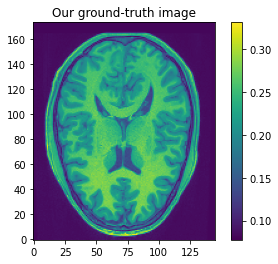

In [11]:
plt.imshow(batch_x[80][0], origin='lower')
plt.colorbar()

plt.title('Our ground-truth image')
plt.show()

In [12]:
#Now get lagrange coefficients for this image

In [21]:
#all required imports

# import
import sys
import os, os.path
import pandas as pd
import numpy as np
import json
# minterpy
import minterpy as mp

import plotly.express as px
import plotly.graph_objects as go

from matplotlib import pyplot as plt

#sys.path.append('../../code-pkg')
#sys.path.append('/home/chethan/Project')
#sys.path

import pkg as util

import numpy as np
import minterpy as mp
from minterpy.extras.regression import *
from matplotlib import pyplot as plt



In [14]:
function_vals = batch_x[80][0]
function_vals_flat = function_vals.reshape(function_vals.shape[0]*function_vals.shape[1])


In [15]:
lat = np.array([[i]*174 for i in range(145)]) 
lon = np.array([list(range(145)) for i in range(174)])
height, width = function_vals.shape
grid_len = height * width
geo = np.hstack([lon.reshape((grid_len, 1)), lat.reshape((grid_len, 1))])

In [20]:
sdt = ScatteredDecompositionTree(geo, function_vals_flat,
                                 poly_degree=8, lp_degree=2.0)

NameError: name 'ScatteredDecompositionTree' is not defined

In [17]:
sdt.subdivide([18,18])
sdt.show()

Node has 324 children with
box_mins [0. 0.] and box_maxs [145.44 145.44]
#0 Node with m=2, n=8, lp_deg=2.0, num_points=99
   box_mins=[0. 0.] and box_maxs=[8.08 8.08]
#1 Node with m=2, n=8, lp_deg=2.0, num_points=90
   box_mins=[0.   8.08] and box_maxs=[ 8.08 16.16]
#2 Node with m=2, n=8, lp_deg=2.0, num_points=81
   box_mins=[ 0.   16.16] and box_maxs=[ 8.08 24.24]
#3 Node with m=2, n=8, lp_deg=2.0, num_points=90
   box_mins=[ 0.   24.24] and box_maxs=[ 8.08 32.32]
#4 Node with m=2, n=8, lp_deg=2.0, num_points=90
   box_mins=[ 0.   32.32] and box_maxs=[ 8.08 40.4 ]
#5 Node with m=2, n=8, lp_deg=2.0, num_points=81
   box_mins=[ 0.  40.4] and box_maxs=[ 8.08 48.48]
#6 Node with m=2, n=8, lp_deg=2.0, num_points=90
   box_mins=[ 0.   48.48] and box_maxs=[ 8.08 56.56]
#7 Node with m=2, n=8, lp_deg=2.0, num_points=81
   box_mins=[ 0.   56.56] and box_maxs=[ 8.08 64.64]
#8 Node with m=2, n=8, lp_deg=2.0, num_points=90
   box_mins=[ 0.   64.64] and box_maxs=[ 8.08 72.72]
#9 Node with m=2, n=8

In [18]:
reg_tree = mp.windowed_regression_scattered(sdt)
reg_tree.show()

/home/ramana44/minterpy/src/minterpy/schemes/barycentric/operators.py:44: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn(


Node has 324 children
#0 Node with n=8, lp_deg=2.0, with error_values 0.0023674284582125005
#1 Node with n=8, lp_deg=2.0, with error_values 0.0013054311275482178
#2 Node with n=8, lp_deg=2.0, with error_values 0.00260799378156662
#3 Node with n=8, lp_deg=2.0, with error_values 0.0015284307301044464
#4 Node with n=8, lp_deg=2.0, with error_values 0.0025380700826644897
#5 Node with n=8, lp_deg=2.0, with error_values 0.0017939135432243347
#6 Node with n=8, lp_deg=2.0, with error_values 0.002040952444076538
#7 Node with n=8, lp_deg=2.0, with error_values 0.0017741918563842773
#8 Node with n=8, lp_deg=2.0, with error_values 0.0020034313201904297
#9 Node with n=8, lp_deg=2.0, with error_values 0.0013562142848968506
#10 Node with n=8, lp_deg=2.0, with error_values 0.0010608956217765808
#11 Node with n=8, lp_deg=2.0, with error_values 0.001987764611840248
#12 Node with n=8, lp_deg=2.0, with error_values 0.0017466315476083183
#13 Node with n=8, lp_deg=2.0, with error_values 0.001426689326763153

In [19]:
reg_vals = reg_tree.evaluate_at(geo, sdt)
reg_vals.shape

(25230,)

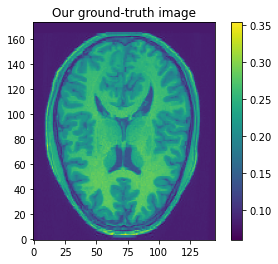

In [20]:
plt.imshow(reg_vals.reshape(function_vals.shape[0],function_vals.shape[1]), origin='lower')
plt.colorbar()
plt.title('Our ground-truth image')
plt.show()

In [21]:
#get merged polynomial
geo = geo.astype(float)
lag_poly = merge_tree(reg_tree, sdt, poly_degree = 30)

transform_l2n = mp.get_transformation(lag_poly, mp.NewtonPolynomial)
newt_poly = transform_l2n()

merge_reg_vals = newt_poly(geo)

In [22]:
lag_coeffs = lag_poly.coeffs
lag_coeffs.shape

(736,)

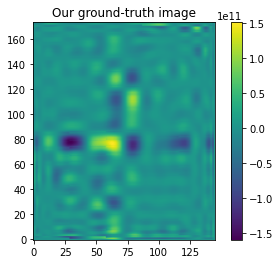

In [23]:
plt.imshow(merge_reg_vals.reshape(function_vals.shape[0],function_vals.shape[1]), origin='lower')
plt.colorbar()
plt.title('Our ground-truth image')
plt.show()

In [24]:
linear_size_x = 145
linear_size_y = 174
xvals = np.linspace(0.0, 1.0, linear_size_x)
yvals = np.linspace(0.0, 1.0, linear_size_y)
X,Y = np.meshgrid(xvals, yvals)
coords = np.zeros((linear_size_x*linear_size_y,2))
coords[:,0] = X.reshape(-1)
coords[:,1] = Y.reshape(-1)

'''function_vals = np.zeros(linear_size_x*linear_size_y)
for i in range(linear_size_x*linear_size_y):
    function_vals[i] = runge(coords[i,0], coords[i,1])'''


#function_vals = ex_image
    
sample_points = coords

In [14]:
batch_x = next(iter(train_loader))
batch_x[0][0].shape

torch.Size([174, 145])

In [15]:
#precalculations before function call

lat = np.array([[i]*174 for i in range(145)]) 
lon = np.array([list(range(145)) for i in range(174)])
height, width = batch_x[0][0].shape
grid_len = height * width
geo = np.hstack([lon.reshape((grid_len, 1)), lat.reshape((grid_len, 1))])


In [18]:
#input_batch = batch_x

def get_image_lagrange_coeffs(input_image):

    function_vals = input_image
    function_vals_flat = function_vals.reshape(function_vals.shape[0]*function_vals.shape[1])

    sdt = ScatteredDecompositionTree(geo, function_vals_flat,
                                    poly_degree=8, lp_degree=2.0)
    sdt.subdivide([18,18])
    reg_tree = mp.windowed_regression_scattered(sdt)
    lag_poly = merge_tree(reg_tree, sdt, poly_degree = 30)
    lag_coeffs_t = lag_poly.coeffs
    return lag_coeffs_t

In [22]:
input_image_1 = batch_x[80][0]

check = get_image_lagrange_coeffs(input_image_1)

/home/ramana44/minterpy/src/minterpy/schemes/barycentric/operators.py:44: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn(


In [28]:
print(check.shape)

(736,)


In [24]:
# get batch lagrange coefficients
for i in range(batch_x.shape[0]-197):
    check = get_image_lagrange_coeffs(batch_x[i][0])
    check_t = torch.tensor(check)
    print(check_t.shape)

/home/ramana44/minterpy/src/minterpy/schemes/barycentric/operators.py:44: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn(


In [1]:
print(check_t)

NameError: name 'check_t' is not defined